In [1]:
!pip install nltools

     |████████████████████████████████| 3.3 MB 1.9 MB/s            
     |████████████████████████████████| 5.9 MB 8.0 MB/s            
     |████████████████████████████████| 379 kB 6.9 MB/s            


In [2]:
!tree -L 1 '../data/ds000030/derivatives/fmriprep/'

../data/ds000030/derivatives/fmriprep/
├── dataset_description.json
├── sub-10171
├── sub-10292
├── sub-10365
├── sub-10565
├── sub-11106
└── sub-11122

6 directories, 1 file


In [3]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data
from nltools.plotting import component_viewer

base_dir = '../data/ds000030/derivatives/fmriprep'
sub = '10565'

data = Brain_Data(os.path.join(base_dir, f'sub-{sub}','func', f'sub-{sub}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Фильтр верхних частот, чтобы удалить дрейф низкочастотного сканера. 

In [4]:
t_r = 2
sampling_freq = 1 / t_r
high_pass = 1 / 128

data = data.filter(sampling_freq, high_pass)

Пространственное сглаживание с гауссовым ядром FWHM 6 мм, чтобы увеличить отношение сигнал/шум в каждом вокселе

In [5]:
data = data.smooth(6)

# 1. Independent Component Analysis (ICA)

**ICA пытается выполнить слепое разделение источников путем разложения многомерного сигнала на аддитивные подкомпоненты, которые являются максимально независимыми.**



In [6]:
output = data.decompose(algorithm='ica', n_components=30, axis='images', whiten=True)

**Компоненты стандартизированы**, это позволяет нам задавать пороговое значение с точки зрения стандартных отклонений. Например, пороговое значение по умолчанию 2,0 означает, что любой воксель, который загружает компонент больше или меньше 2 стандартных отклонений, будет наложен на стандартный мозг. Вы можете играть с различными порогами, чтобы быть более или менее инклюзивным — порог 0 будет накладываться на все воксели.

**Второй график — это временной ряд вокселей**, которые загружаются в компонент. Ось X находится в TR, что для этого набора данных составляет 2 секунды.

**Третий график — это спектр мощности течения времени.** Существует небольшой диапазон возможных значений, поскольку мы можем наблюдать сигналы только на частоте Найквиста, которая составляет половину нашей частоты дискретизации 1/2 с (приблизительно 0,21 Гц) до нижней границы 0,0078 Гц на основе нашего фильтра верхних частот. . Могут быть систематические колебательные сигналы. Помните, что сигналы, которые колеблются на более высокой частоте, чем частота Найквиста, будут накладываться. Это включает в себя физиологические артефакты, такие как дыхание и сердечные сигналы.

Важно отметить, что ICA не может разрешить знак компонента. Поэтому убедитесь, что вы учитываете как положительные, так и отрицательные сигналы.

In [7]:
component_viewer(output, tr=t_r)

interactive(children=(BoundedIntText(value=0, description='Component', max=29), BoundedFloatText(value=2.0, de…

In [8]:
from IPython.display import IFrame
IFrame('./static/Noises.pdf', width=1200, height=600)

- 11 - susceptibility motion noise component
- 13 - CSF noise component

# 2. Работа с сигналом

### 2..1 Посмотрим на **Hemodynamic Responce Function**

Text(0.5, 1.0, 'Hemodynamic responce function')

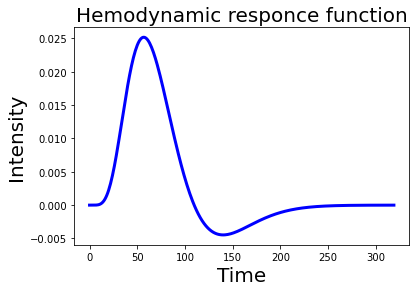

In [12]:
from nltools.external import glover_hrf

hrf_function = glover_hrf(tr=t_r, oversampling=20)

plt.plot(hrf_function, linewidth=3, color='blue')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.title('Hemodynamic responce function', fontsize=20)

- На практике мы хотим убедиться, что ядро ​​имеет правильную форму с учетом нашего разрешения выборки. 
- **Установим передискретизацию на 1.**

Text(0.5, 1.0, 'Hemodynamic responce function')

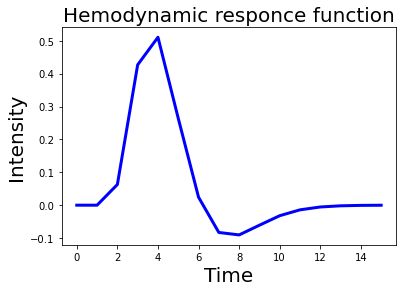

In [13]:
hrf_function = glover_hrf(tr=t_r, oversampling=1)

plt.plot(hrf_function, linewidth=3, color='blue')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.title('Hemodynamic responce function', fontsize=20)

### 2.2 Свертка

Text(0.5, 1.0, 'Signal convolved with HRF kernel')

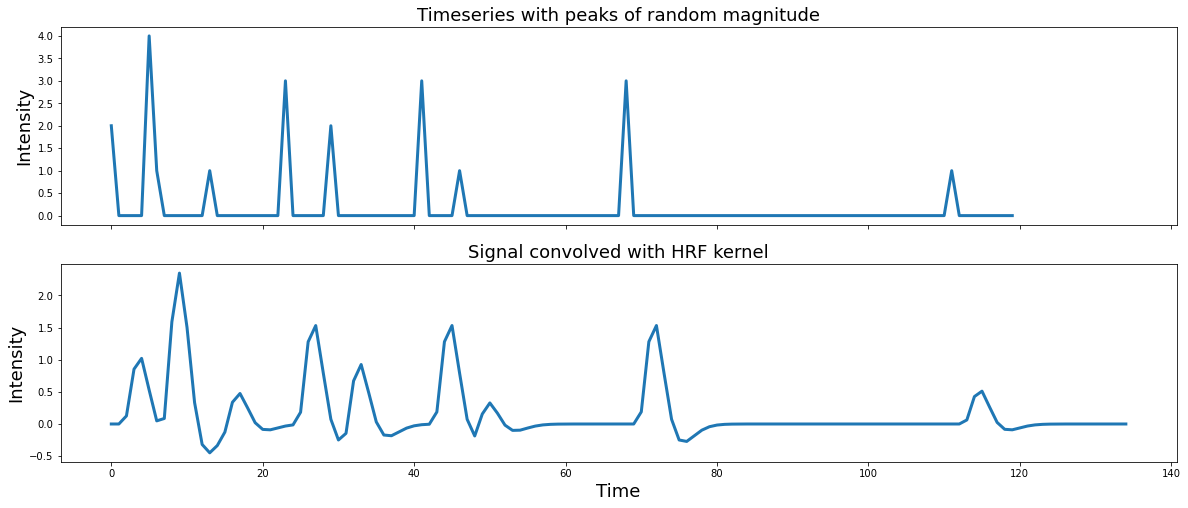

In [14]:
import numpy as np

# Формируем сигнал
n_samples = 120
signal = np.zeros(n_samples)
signal[np.random.randint(0, n_samples, 10)] = np.random.randint(1, 5, 10)

fig, ax = plt.subplots(nrows=2, figsize=(20,8), sharex=True)
ax[0].plot(signal, linewidth=3)
ax[1].plot(np.convolve(signal, hrf_function), linewidth=3)
ax[0].set_ylabel('Intensity', fontsize=18)
ax[0].set_title('Timeseries with peaks of random magnitude', fontsize=18)
ax[1].set_ylabel('Intensity', fontsize=18)
ax[1].set_xlabel('Time', fontsize=18)
ax[1].set_title('Signal convolved with HRF kernel', fontsize=18)

### 2.3 Колебания (Oscillations)

$A\sin(2 \pi ft + \theta)$

где $f$ - частота или скорость колебаний, выраженная в числе циклов в секунду - $Hz$. Амплитуда $A$ относится к высоте волн, которая составляет половину расстояния от пика до впадины. Наконец, $\theta$ описывает смещение фазового угла, выраженное в радианах.

In [15]:
class SineWave:
    
    def __init__(self, sampling_freq, amplitude, freq, phases):
        self.amplitude = amplitude
        self.freq = freq
        self.phases = phases
        self.time = np.arange(-1, 1 + 1/sampling_freq, 1/sampling_freq)
    
    def sine(self):
        return self.amplitude * np.sin(2*np.pi * self.freq * self.time + self.phases)

In [16]:
def plot_waves(n_waves, sine_waves_signal, title):
    f,a = plt.subplots(nrows=n_waves, ncols=1, figsize=(12,5), sharex=True)
    for i in range(n_waves):
        a[i].plot(sine_waves_signal[i,:], linewidth=2)
    a[0].set_title(title, fontsize=18)
    a[i].set_xlabel("Time", fontsize=18)
    plt.tight_layout()

**Создадим несколько синусоидальных волн, колеблющихся на разных частотах.**

In [17]:
# Определим параметры
waves_parameters = {
    'sampling_freq': 500,
    'amplitude': [3, 11, 5, 15, 7],
    'freq': [3, 10, 5, 15, 35],
    'phases': np.pi * np.array([1/7, 1/8, 1, 1/2, -1/4])
}

# Сформируем различные волны
def create_waves(sampling_freq, amplitude, freq, phases):
    sine_waves = []
    for i, f in enumerate(freq):
        wave = SineWave(sampling_freq, amplitude[i], f, phases[i])
        sine_waves.append(wave.sine())
    sine_waves = np.array(sine_waves)
    return sine_waves

sine_waves = create_waves(waves_parameters['sampling_freq'], 
                          waves_parameters['amplitude'],
                          waves_parameters['freq'],
                          waves_parameters['phases'])

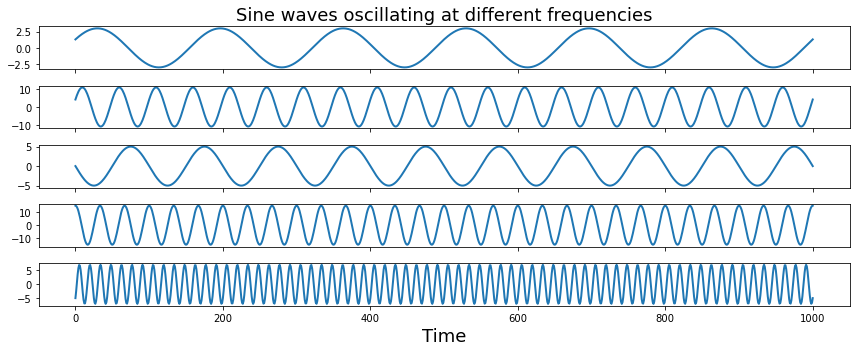

In [18]:
plot_waves(n_waves=len(waves_parameters['freq']), sine_waves_signal=sine_waves,
          title="Sine waves oscillating at different frequencies")

array([15.56142151, 18.90183548, 22.08491621, ..., 10.24864503,
       12.56355284, 15.56142151])

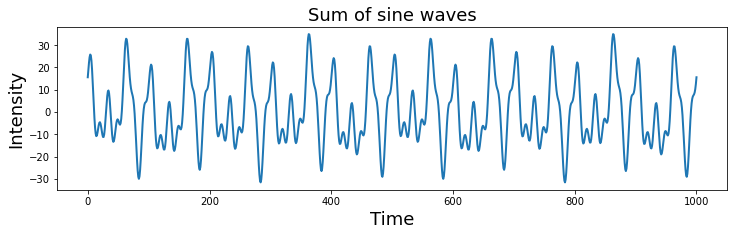

In [19]:
# Попробуем сложить все эти сигналы
def plot_sum_waves(sine_waves_signal, add_noise=False):
    
    sum_signal = np.sum(sine_waves_signal, axis=0)
    
    if add_noise:
        sum_signal += 5 * np.random.randn(sine_waves_signal.shape[1])
        
    plt.figure(figsize=(12,3))
    plt.plot(sum_signal, linewidth=2)
    plt.title("Sum of sine waves", fontsize=18)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    return sum_signal
    
plot_sum_waves(sine_waves_signal=sine_waves)

#### Частота дискретизации

- Обратим внимание на то, как влияет изменение частоты дискретизации на нашу способность измерять волны и колебания. 
- На практике более высокие частоты дискретизации позволяют нам лучше наблюдать лежащие в основе сигналы.
- **Обратим внимание на зубчатость сигналов там, где наша частота выше частоты Найквиста - у нас недостаточно наблюдений, чтобы точно уловить колебания**

array([ 15.56142151,  12.29081474,  -8.18023139, -11.20747646,
         9.49830958, -13.2549499 ,  -3.67235018,  13.01576615,
        24.75044011,   5.33752991, -29.63889846,   0.49191712,
        11.61798369,   7.26583803, -13.79486727, -16.86217183,
         4.3570757 , -17.37946249,  -6.37640546,  11.99685996,
        25.51642064,   7.81341766, -25.69546064,   5.51689383,
        17.23261957,  12.92053339,  -8.65363339, -12.73765924,
         7.06113097, -16.3605563 ,  -7.14238599,   9.52097221,
        21.57298283,   2.78844095, -31.31009653,  -0.13780154,
        12.0913857 ,   8.7960208 , -11.35768867, -13.75656543,
         7.82711151, -13.88466856,  -3.19894818,  14.54594893,
        27.18761871,   8.44313632, -26.16886265,   3.98671105,
        14.79544097,   9.81492699, -12.1236692 , -16.23245317,
         3.88367369, -18.90964527,  -8.81358406,   8.89125356,
        22.04638483,   4.31862372, -28.87291792,   2.96780486,
        15.56142151,  12.29081474,  -8.18023139, -11.20

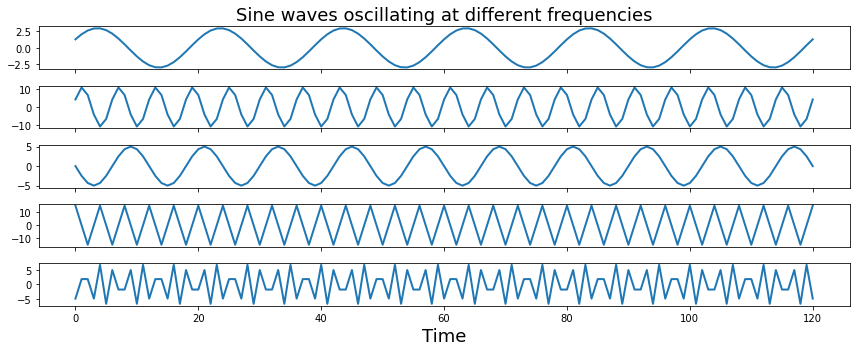

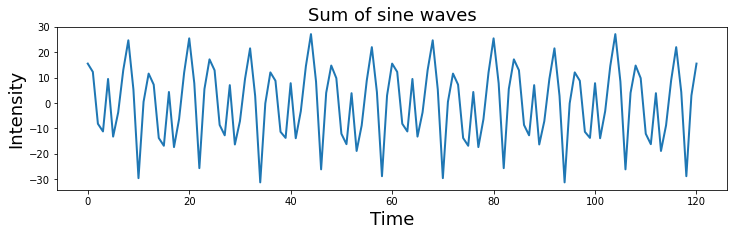

In [21]:
# Изменяем частоту дискретизации
waves_parameters['sampling_freq'] = 60

# Рассчитываем волны с новым параметром
sine_waves = create_waves(waves_parameters['sampling_freq'], 
                          waves_parameters['amplitude'],
                          waves_parameters['freq'],
                          waves_parameters['phases'])

# Рисуем все волны
plot_waves(n_waves=len(waves_parameters['freq']), sine_waves_signal=sine_waves,
          title="Sine waves oscillating at different frequencies")

# Суммируем
plot_sum_waves(sine_waves_signal=sine_waves)

- Увеличим частоту
- Добавим немного шума

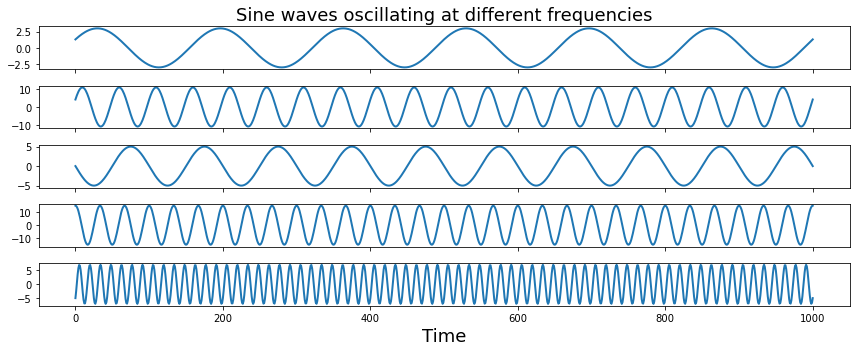

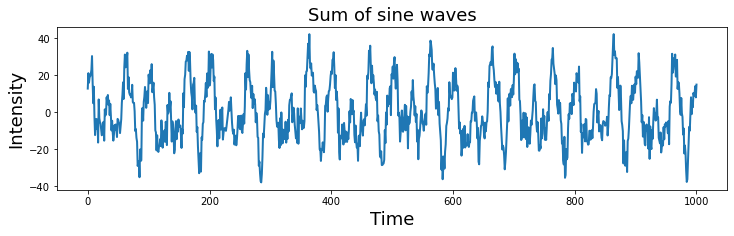

In [23]:
# Изменяем частоту дискретизации
waves_parameters['sampling_freq'] = 500

# Рассчитываем волны с новым параметром
sine_waves = create_waves(waves_parameters['sampling_freq'], 
                          waves_parameters['amplitude'],
                          waves_parameters['freq'],
                          waves_parameters['phases'])

# Рисуем все волны
plot_waves(n_waves=len(waves_parameters['freq']), sine_waves_signal=sine_waves,
          title="Sine waves oscillating at different frequencies")

# Суммируем, добавляя шум
signal = plot_sum_waves(sine_waves_signal=sine_waves, add_noise=True)

# 3. Time & Frequency Domains
## 3.1 Frequency Domain
- Обычно, наблюдая за сигналом мы хотим раскрыть ненеративные процессы, которые этот сигнал породили
- Частотная область, при опр. условиях, помогает определить есть ли какие-то частоты в нашем сигнале, которые колеблются с постоянной частотой
- Делается это при помощи преобразования Фурье

<img src="./static/Time_and_Freq_domain_1.png"/>

<img src="./static/Time_and_Freq_domain_2.png"/>

## 3.2 Discrete Time Fourier Transform
### 3.2.1 Complex Sine Waves

$$\text{complex sine wave} = e^{i(2\pi ft + \theta)}$$
- $f$ - частота
- $t$ - время
- $\theta$ - фаза

In [24]:
class ComplexSineWave:
    
    def __init__(self, sampling_freq, amplitude, freq, phases):
        self.amplitude = amplitude
        self.freq = freq
        self.phases = phases
        
    
    def compute_sine(self, time):
        return np.exp(1j*(2 * np.pi * self.freq * time + self.phases))

In [25]:
signal.shape

(1001,)

In [26]:
time = np.arange(0, len(signal), 1)/len(signal)

complex_wave = ComplexSineWave(500, 5, 5, 5)
z = complex_wave.compute_sine(time)

- **Реальный и мнимый (sin, cosin) сдвинуты по фазе на $\frac{\pi}{2}$**

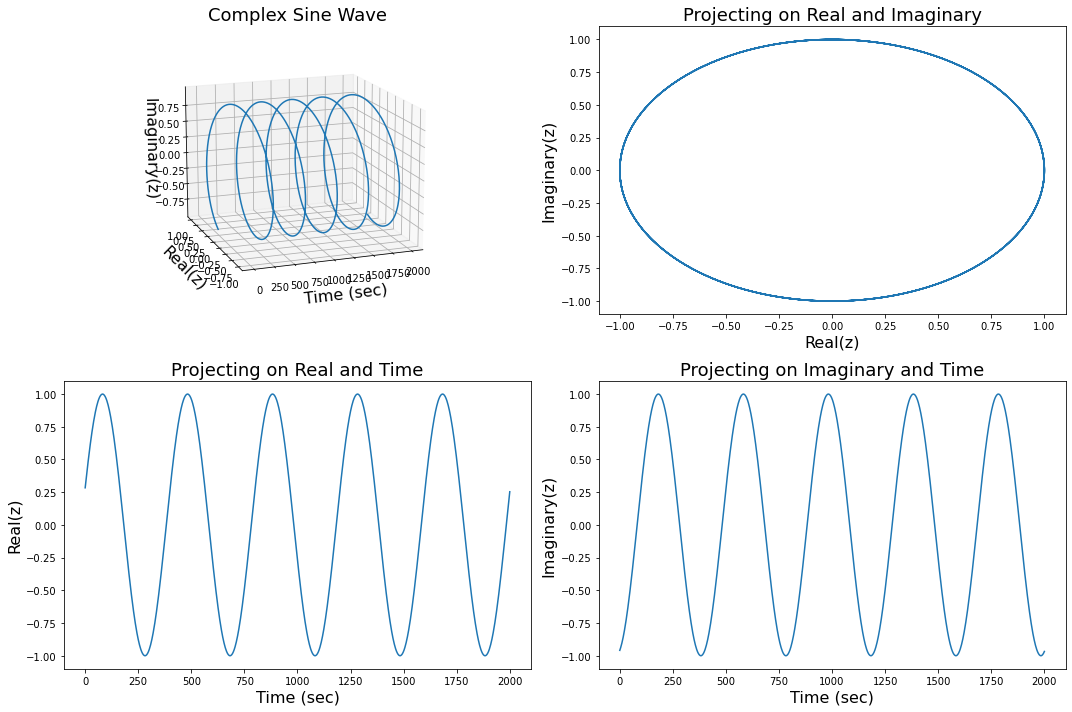

In [27]:
fig= plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot(np.arange(0, len(time))/sampling_freq, np.real(z), np.imag(z))
ax.set_xlabel('Time (sec)', fontsize=16)
ax.set_ylabel('Real(z)', fontsize=16)
ax.set_zlabel('Imaginary(z)', fontsize=16)
ax.set_title('Complex Sine Wave', fontsize=18)
ax.view_init(15, 250)

ax = fig.add_subplot(2, 2, 2)
ax.plot(np.real(z), np.imag(z))
ax.set_xlabel('Real(z)', fontsize=16)
ax.set_ylabel('Imaginary(z)', fontsize=16)
ax.set_title('Projecting on Real and Imaginary', fontsize=18)

ax = fig.add_subplot(2, 2, 3)
ax.plot(np.arange(0, len(time))/sampling_freq, np.real(z))
ax.set_xlabel('Time (sec)', fontsize=16)
ax.set_ylabel('Real(z)', fontsize=16)
ax.set_title('Projecting on Real and Time', fontsize=18)

ax = fig.add_subplot(2, 2, 4,)
ax.plot(np.arange(0, len(time))/sampling_freq, np.imag(z))
ax.set_xlabel('Time (sec)', fontsize=16)
ax.set_ylabel('Imaginary(z)', fontsize=16)
ax.set_title('Projecting on Imaginary and Time', fontsize=18)
plt.tight_layout()

### 3.2.2 Комплексные синусоиды различных частот
- Мы хотим получить скалярное произведение сигнала и комплексных синусоид разных частот
- Создадим их
- Первая базисная функция представляет собой нулевую частотную составляющую и отражает среднее смещение по всему сигналу.

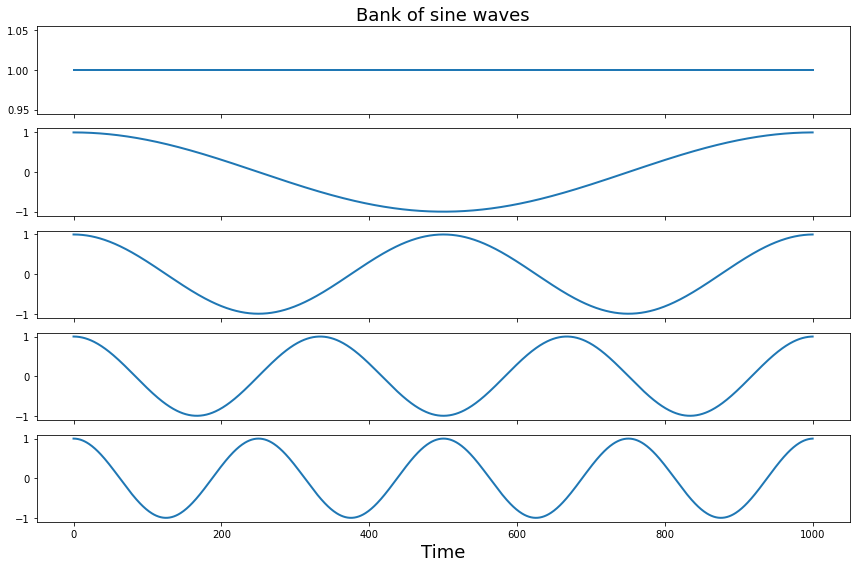

In [28]:
time_points = np.arange(0, len(signal), 1)/len(signal)

complex_sine_waves = []
for curr_freq in range(len(signal)):
    complex_wave = ComplexSineWave(sampling_freq=len(signal),
                                  amplitude=5,
                                  freq=curr_freq,
                                  phases=0)
    complex_sine_waves.append(complex_wave.compute_sine(time_points))
complex_sine_waves = np.array(complex_sine_waves)

f,a = plt.subplots(nrows=5, figsize=(12,8), sharex=True)
for i in range(0,5):
    a[i].plot(complex_sine_waves[i,:], linewidth=2)
a[0].set_title('Bank of sine waves', fontsize=18)
a[i].set_xlabel('Time', fontsize=18)
plt.tight_layout()

### 3.2.3 Оценка Коэффициента Фурье
- Возьмем скалярное произведение синусоид на сигнал

In [29]:
fourier = np.dot(signal, complex_sine_waves)
scaled_fourier = 2 * fourier / len(signal)

### 3.2.4 Визуализация

-  Мы можем оценить только частоты, составляющие половину частоты дискретизации, это называется частотой Найквиста.
-  Мы отображаем только первую половину частот. Мы рисуем только положительные частоты. 
-  Отрицательные - это частоты выше частоты Найквиста

- **Мы видим 5 различных частот с различными амплитудами**
- **Эти данные были смоделированы нами из 5 различных синусоид с разными частотами и амплитудами.**

Text(0.5, 1.0, 'Power spectrum derived from discrete fourier transform')

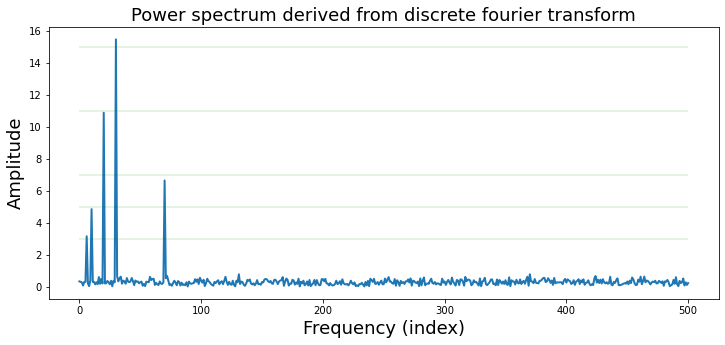

In [30]:
# Они отражены, поэтому строим до 501
plt.figure(figsize=(12, 5))
plt.plot(np.abs(scaled_fourier[0:int(np.ceil(len(scaled_fourier)/2))]), linewidth=2)
for amplitude in waves_parameters['amplitude']:
    plt.hlines(amplitude, 0, 500, color='green', linewidth=0.2)
plt.xlabel('Frequency (index)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('Power spectrum derived from discrete fourier transform', fontsize=18)

- **Преобразуем частоты в Гц**

In [35]:
np.fft.fftfreq?

Text(0.5, 1.0, 'Power spectrum derived from discrete fourier transform')

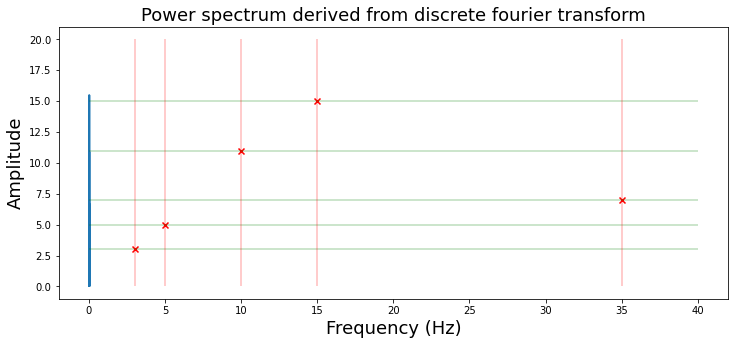

In [34]:
freq = np.fft.fftfreq(len(signal), 1/sampling_freq)

plt.figure(figsize=(12,5))
plt.plot(freq[:80], np.abs(scaled_fourier)[0:80], linewidth=2)
for amplitude in waves_parameters['amplitude']:
    plt.hlines(amplitude, 0, 40, color='green', linewidth=0.4)
for curr_freq in waves_parameters['freq']:
    plt.vlines(curr_freq, 0, 20, color='red', linewidth=0.4)
plt.scatter(waves_parameters['freq'], waves_parameters['amplitude'], marker='x', color='red')
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('Power spectrum derived from discrete fourier transform', fontsize=18)

## 3.2.5 Обратный переход

- Восстанавливаем сигнал в time domain
- Для этого помножим коэффициенты на шаблон комплексной синусоидальной волны

**Для чего?**
- Фильтрация частот
- Ускорение вычислений - Convolution Theorem

Text(0.5, 1.0, 'Reconstructed Time Series Signal')

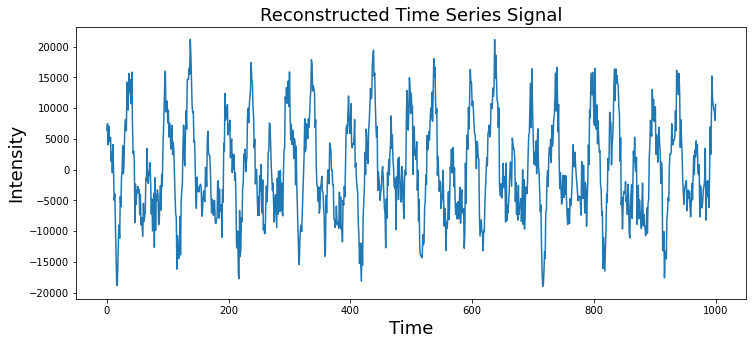

In [33]:
plt.figure(figsize=(12,5))
plt.plot(np.dot(fourier, complex_sine_waves)/2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Reconstructed Time Series Signal', fontsize=18)

## 3.2.6 Теорема свертки
- **Мы можем произвести свертку в частотной обрасти. Это будет абсолютно эквивалентно свертке во временной области, но при этом гораздо дешевле:**
        1. Переводим во Freq. domain сигнал и ядро
        2. Перемножаем коэффициенты Фурье
        3. Делаем обратное преобразование в Time domain